In [1]:
# Reference:
#    https://github.com/ebonilla/mtgp
#    https://proceedings.neurips.cc/paper/2007/file/66368270ffd51418ec58bd793f2d9b1b-Paper.pdf
#    https://gpflow.readthedocs.io/en/master/notebooks/advanced/coregionalisation.html
#    
#
import numpy as onp
onp.set_printoptions(precision=3,suppress=True)
from sklearn.metrics import mean_squared_error

import jax
import jax.numpy as np
from jax import grad, jit, vmap, device_put, random

import matplotlib.pyplot as plt
import matplotlib as mpl
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 25
mpl.rcParams['font.family'] = 'Times New Roman'
cmap = plt.cm.get_cmap('bwr')


from tabulate import tabulate

import sys
sys.path.append('../kernel')
from jaxkern import (cov_se, LookupKernel, normalize_K, mtgp_k)

from plt_utils import plt_savefig, plt_scaled_colobar_ax
from gp import gp_regression_chol, run_sgd, log_func_default
from gpax import *

In [6]:

## Parameters

M = 2
n_train = 150
n_test = 100
ylim = (-3,3)
xlim = (-.2,1.2)
σn = [.03, .1]
ℓ = .2
mtl = True
lr = .002
num_steps = 600
verbose = True
opt = 'sgd'


## Data
key = jax.random.PRNGKey(0)
onp.random.seed(0)

X0 = np.sort(random.uniform(key, (n_train*2//3, 1)), axis=0)
X1 = np.sort(random.uniform(key, (n_train-len(X0), 1))*.5, axis=0)
X_train = np.vstack((np.hstack((X0, np.zeros_like(X0))),
                     np.hstack((X1, np.ones_like(X1)))))

f0 = lambda X: np.sin(6*X)
f1 = lambda X: np.sin(6*X + .7)
fs = [f0,f1]
Y0 = f0(X0) + random.normal(key, X0.shape)*σn[0]
Y1 = f1(X1) + random.normal(key, X1.shape)*σn[1]
y_train = np.vstack((Y0,Y1))

data = (X_train, y_train)

X_test = np.vstack((np.tile(np.linspace(xlim[0], xlim[1], n_test), M),
                    np.hstack([t*np.ones(n_test) for t in range(M)]))).T

print(X_test.shape)


(200, 2)


[  0]	Loss=154.490	k.ks_0.σ2=0.543	k.ks_0.ℓ=0.535	k.ks_1.W=[]	k.ks_1.v[:5]=[0.541 0.541]	lik.σ2[:5]=[0.489 0.514]
[100]	Loss=-198.778	k.ks_0.σ2=0.734	k.ks_0.ℓ=-0.998	k.ks_1.W=[]	k.ks_1.v[:5]=[0.541 0.541]	lik.σ2[:5]=[-6.43  -3.103]
[200]	Loss=-230.237	k.ks_0.σ2=0.826	k.ks_0.ℓ=-0.936	k.ks_1.W=[]	k.ks_1.v[:5]=[0.541 0.541]	lik.σ2[:5]=[-7.142 -4.855]
[300]	Loss=-230.321	k.ks_0.σ2=0.932	k.ks_0.ℓ=-0.921	k.ks_1.W=[]	k.ks_1.v[:5]=[0.541 0.541]	lik.σ2[:5]=[-7.143 -4.904]
[400]	Loss=-230.384	k.ks_0.σ2=1.025	k.ks_0.ℓ=-0.908	k.ks_1.W=[]	k.ks_1.v[:5]=[0.541 0.541]	lik.σ2[:5]=[-7.143 -4.905]
[500]	Loss=-230.408	k.ks_0.σ2=1.108	k.ks_0.ℓ=-0.897	k.ks_1.W=[]	k.ks_1.v[:5]=[0.541 0.541]	lik.σ2[:5]=[-7.143 -4.906]
[  0]	Loss=154.417	k.ks_0.σ2=0.543	k.ks_0.ℓ=0.535	k.ks_1.W[:5]=[[0.101 0.101]
 [0.101 0.101]]	k.ks_1.v[:5]=[0.543 0.541]	lik.σ2[:5]=[0.489 0.514]
[100]	Loss=-199.525	k.ks_0.σ2=0.714	k.ks_0.ℓ=-0.951	k.ks_1.W[:5]=[[0.234 0.234]
 [0.205 0.205]]	k.ks_1.v[:5]=[0.668 0.565]	lik.σ2[:5]=[-6.442 -3.11 ]


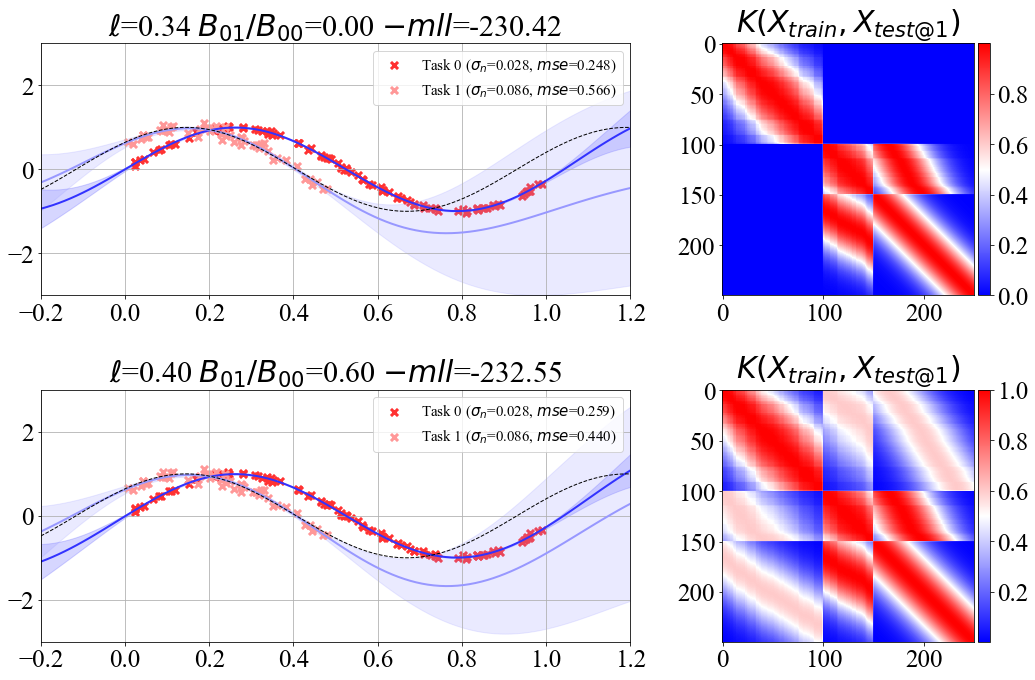

In [7]:

## Plotting

        
def log_func(i, f, params):
    if verbose:
        print(tabulate([[f(params)]+[x.item() if x.size==1 else x for x in list(params.values())]],
                       tablefmt="plain",
                       floatfmt=".3f",
                       headers=['loss']+list(params.keys()) if i == 0 else ()))


colors_b = [cmap(.1), cmap(.3)]
colors_r = [cmap(.9), cmap(.7)]

gridspec_kw = {'width_ratios': [2, 1], 'height_ratios': [1, 1]}
fig, axs = plt.subplots(2, 2, gridspec_kw=gridspec_kw)
fig.set_size_inches(15, 10)


for i, mtl in enumerate([False, True]):
    ax = axs[i, 0]
    
    ## model
    
    if mtl:
        rank = 2
        optimizer_focus = None
    else:
        rank = 0
        optimizer_focus = optim.ModelParamTraversal(
            lambda k, v: filter_contains(k, v, 'ks_1', False))
    
    class MTGP(GPR):
        def setup(self):
            self.k = compose_kernel(CovSE(active_dims=[0]),
                                    CovIndex(active_dims=[1], output_dim=2, rank=rank),
                                    np.multiply)
            self.lik = LikMultipleNormal(2)


    ## Training

    model = MTGP((X_train, y_train))
    params = model.get_init_params(key)
    @jax.jit
    def nmll(params):
        return -model.apply(params, method=model.mll)
    params = flax_run_optim(nmll, params, num_steps=num_steps,
                            optimizer_kwargs={'learning_rate': 0.002},
                            optimizer_focus=optimizer_focus,
                            log_func=lambda i,f,params: log_func_default(i,f,params,100))

    ## Plotting

    model = MTGP(data)
    model = model.bind(params)
    
    mll = model.mll()
    μ, Σ = model.pred_f(X_test, full_cov=False)
    std = np.sqrt(Σ)
    ℓ = model.k.ks[0].ℓ[0]
    σn = np.sqrt(model.lik.σ2)
    B = model.k.ks[1].cov()
    
    for t in range(M):
        # task-specific mll
        I = X_test[:,1] == t
        # posterior predictive distribution
        X_test_, μ_, std_ = X_test[I,0].squeeze(), μ[I].squeeze(), std[I].squeeze()
        ax.plot(X_test_, μ_, color=colors_b[t], lw=2)
        ax.fill_between(X_test_, μ_-2*std_, μ_+2*std_, alpha=.2, color=colors_b[t])
        # generating function for main task
        if t == 1:
            ax.plot(X_test_, fs[t](X_test_), color='k', linestyle='dashed', linewidth=1)
        
        mse = mean_squared_error(μ[I], f1(X_test[I,0]))
        # train data points
        I = X_train[:,1] == t
        ax.scatter(X_train[I,0], y_train[I],
                   marker='x', color=colors_r[t], s=50,
                   label=f'Task {t}'+' ($\sigma_n$'+f'={σn[t]:.3f}, '+'$mse$'+f'={mse:.3f})')
        
    ax.grid()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(fontsize=15)
    title = '$\ell$'+f'={ℓ:.2f}'+ \
        ' $B_{01}/B_{00}$'+f'={B[0,1]*2/(B[0,0]+B[1,1]):.2f}'+ \
        ' $-mll$'+f'={-np.array(mll):.2f}'
    ax.set_title(title, fontsize=30)
    

    ax = axs[i, 1]
    XX = np.vstack((X_train, X_test[X_test[:,1]==1]))
    K = model.k(XX)
    im = ax.imshow(normalize_K(K), cmap=cmap)
    fig.colorbar(im, cax=plt_scaled_colobar_ax(ax))
    ax.set_title('$K(X_{train}, X_{test@1})$')
    

fig.tight_layout()
plt_savefig(fig, 'summary/assets/plt_mtgp.png')